dataset link: https://www.kaggle.com/datasets/razinw/dog-vs-cat

# CNN model

In [ ]:
# To get multi output in jupyternotebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


import cv2 # open cv


## ImageDataGenerator ile getirme

In [ ]:
img_size = 180
batch_size = 32

# Grayscale + Augmentasyon (isteğe bağlı)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# 🔥 color_mode='grayscale' çok önemli!
train_data = train_datagen.flow_from_directory(
    "dogvscat/train",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

test_data = test_datagen.flow_from_directory(
    "dogvscat/test",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',#    color_mode='grayscale',
    shuffle=False
)




Found 500 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


<Figure size 1000x500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Gerçek: Köpek')

(np.float64(-0.5), np.float64(179.5), np.float64(179.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'Gerçek: Köpek')

(np.float64(-0.5), np.float64(179.5), np.float64(179.5), np.float64(-0.5))

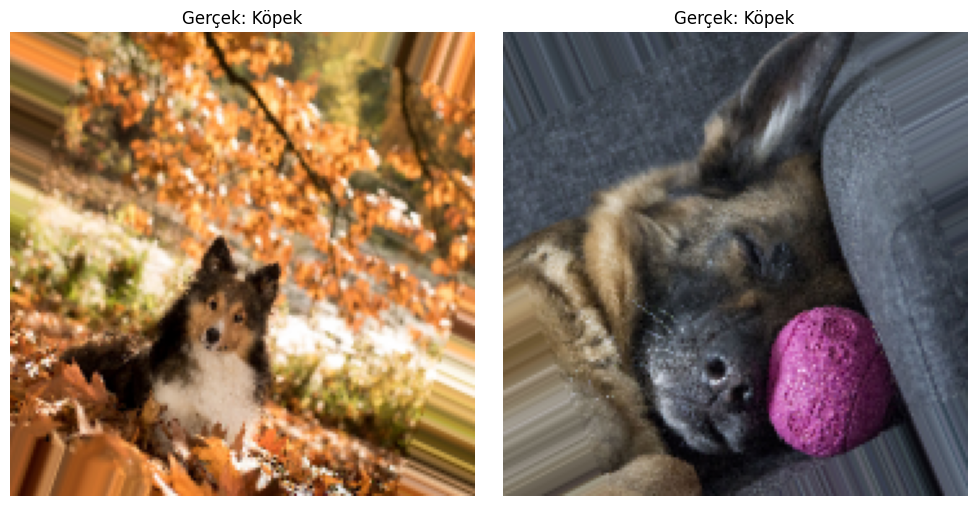

In [24]:
labels = ["Kedi", "Köpek"]  # 0 → Kedi, 1 → Köpek

plt.figure(figsize=(10, 5))

# İlk batch'ten 0. görsel
x_batch, y_batch = train_data[0]
plt.subplot(1, 2, 1)
plt.imshow(x_batch[0].squeeze(), cmap="gray")
plt.title(f"Gerçek: {labels[int(y_batch[0])]}")
plt.axis("off")

# 13. batch'ten (örnek olarak) 0. görsel
x_batch2, y_batch2 = train_data[12]  # 12. batch (32*12 = ~384. görsel)
plt.subplot(1, 2, 2)
plt.imshow(x_batch2[0].squeeze(), cmap="gray")
plt.title(f"Gerçek: {labels[int(y_batch2[0])]}")
plt.axis("off")

plt.tight_layout()
plt.show()


In [25]:
"""
feature Extraction
conv2d -normalization -maxpooling
conv2d-dropout -normalization -maxpooling
conv2d -normalization -maxpooling
conv2d-dropout -normalization -maxpooling
conv2d-dropout -normalization -maxpooling

classification
flatten -dense-dropout-dense(output)
compiler:optimizer(rmsprop),loss(binary class ent.),metric(accuracy)
"""

#feature extraction
model=Sequential()
model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(180,180,3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=2, padding="same"))

model.add(Conv2D(64,(3,3),strides=1,padding="same",activation="relu"))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=2, padding="same"))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=2, padding="same"))


#classification - fully connected layer
model.add(Flatten())
model.add(Dense(units=128,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=1,activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

'\nfeature Extraction\nconv2d -normalization -maxpooling\nconv2d-dropout -normalization -maxpooling\nconv2d -normalization -maxpooling\nconv2d-dropout -normalization -maxpooling\nconv2d-dropout -normalization -maxpooling\n\nclassification\nflatten -dense-dropout-dense(output)\ncompiler:optimizer(rmsprop),loss(binary class ent.),metric(accuracy)\n'

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 67712)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     8,667,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,761,537 (33.42 MB)

 Trainable params: 8,761,089 (33.42 MB)

 Non-trainable params: 448 (1.75 KB)

In [26]:
lr_reduce = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    verbose=1,
    factor=0.3,
    min_lr=1e-5
)


history = model.fit(
    train_data,
    epochs=10,
    validation_data=test_data,
    callbacks=[lr_reduce]
)


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5344 - loss: 9.8889 - val_accuracy: 0.4000 - val_loss: 2.5489 - learning_rate: 0.0010
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5903 - loss: 3.7337 - val_accuracy: 0.5000 - val_loss: 11.4774 - learning_rate: 0.0010
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5867 - loss: 1.3377 - val_accuracy: 0.5200 - val_loss: 10.5154 - learning_rate: 0.0010
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5710 - loss: 0.7194 - val_accuracy: 0.5000 - val_loss: 13.5165 - learning_rate: 0.0010
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6280 - loss: 0.6495
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6286 - loss: 0.6498 - val_accuracy: 0.5000 - val_loss: 15.0267 - learning_rate: 0.0010
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6416 - loss: 0.6340 - val_accuracy

Text(0.5, 0, 'epochs')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epochs')

Text(0, 0.5, 'loss')

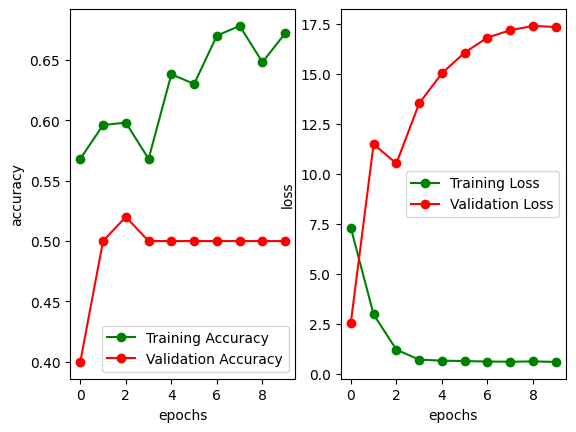

In [27]:
epochs=[i for i in range(10)]

fig,ax=plt.subplots(1,2)

train_acc=history.history["accuracy"]
train_loss=history.history["loss"]

val_acc=history.history["val_accuracy"]
val_loss=history.history["val_loss"]

ax[0].plot(epochs,train_acc,"go-",label="Training Accuracy")
ax[0].plot(epochs,val_acc,"ro-",label="Validation Accuracy")
ax[0].legend()
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("accuracy")

ax[1].plot(epochs,train_loss,"go-",label="Training Loss")
ax[1].plot(epochs,val_loss,"ro-",label="Validation Loss")
ax[1].legend()
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("loss")

In [28]:
test_loss, test_acc = model.evaluate(test_data)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.5938 - loss: 14.0521
Test accuracy: 0.5
Test loss: 17.341270446777344


In [29]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Tüm test verisini ve etiketleri topluyoruz
y_true = []
y_pred = []

for i in range(len(test_data)):
    x_batch, y_batch = test_data[i]
    
    # Tahmin yap
    preds = model.predict(x_batch)
    preds = [1 if p > 0.5 else 0 for p in preds]
    
    y_true.extend(y_batch)
    y_pred.extend(preds)

# Numpy array'e çevir
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion Matrix ve Classification Report
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Kedi", "Köpek"]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Confusion Matrix:
[[25  0]
 [25  0]]

Classification Report:
              precision    recall  f1-score   support

        Kedi       0.50      1.00      0.67        25
       Köpek       0.00      0.00      0.00        25

    accuracy                           0.50        50
   macro avg       0.25      0.50      0.33        50
weighted avg       0.25      0.50      0.33        50



c:\Users\Harun\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Harun\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Harun\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


<Figure size 1500x500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Gerçek: 0\nTahmin: 0')

(np.float64(-0.5), np.float64(179.5), np.float64(179.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'Gerçek: 0\nTahmin: 0')

(np.float64(-0.5), np.float64(179.5), np.float64(179.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'Gerçek: 0\nTahmin: 0')

(np.float64(-0.5), np.float64(179.5), np.float64(179.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'Gerçek: 1\nTahmin: 0')

(np.float64(-0.5), np.float64(179.5), np.float64(179.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'Gerçek: 0\nTahmin: 0')

(np.float64(-0.5), np.float64(179.5), np.float64(179.5), np.float64(-0.5))

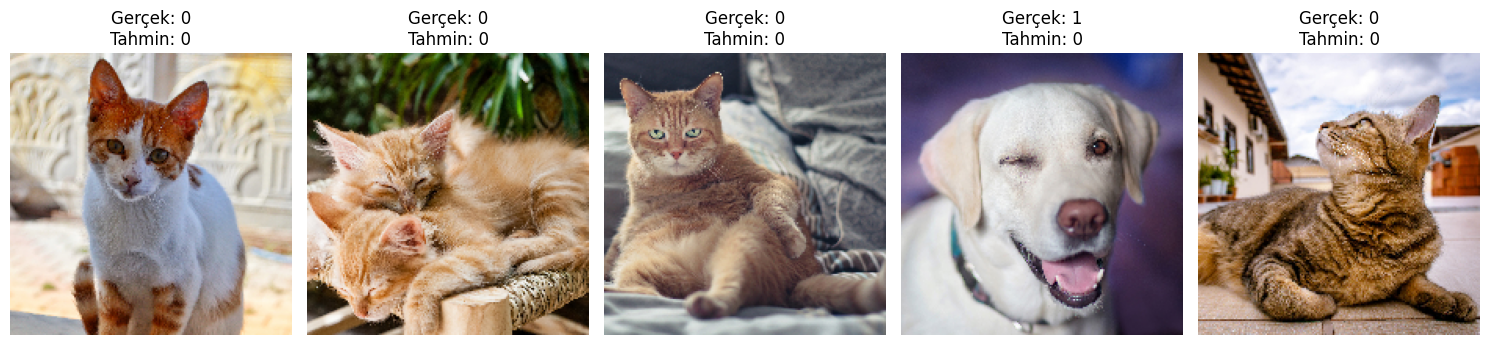

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Kaç resim görmek istiyorsan onu belirle
sample_num = 5  # Örn: 5 adet rastgele örnek
x_test_rgb = test_data[0][0]  # İlk batch'teki resimleri al (test_data flow_from_directory)
y_test_labels = test_data[0][1]

# Rastgele sample'lar al
indices = np.random.choice(len(x_test_rgb), sample_num, replace=False)
sample_images = x_test_rgb[indices]
sample_labels = y_test_labels[indices]

# Tahmin yap
predictions = model.predict(sample_images)
predicted_labels = [1 if p > 0.5 else 0 for p in predictions]

# Görselleştir
plt.figure(figsize=(15, 5))

for i in range(sample_num):
    plt.subplot(1, sample_num, i + 1)
    plt.imshow(sample_images[i])  # RGB olduğu için squeeze veya cmap gerekmez
    plt.title(f"Gerçek: {int(sample_labels[i])}\nTahmin: {predicted_labels[i]}", fontsize=12)
    plt.axis("off")

plt.tight_layout()
plt.show()



# MobileNetV2

In [34]:
img_size = 180
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    "dogvscat/train",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

test_data = test_datagen.flow_from_directory(
    "dogvscat/test",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 500 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [35]:
base_model = MobileNetV2(
    input_shape=(img_size, img_size, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # İlk eğitimde sadece son katmanlar eğitilsin

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)


C:\Users\Harun\AppData\Local\Temp\ipykernel_5272\2337395378.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


In [36]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 90, 90,    │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 90, 90,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 90, 90,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 90, 90,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 90, 90,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 90, 90,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 90, 90,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 90, 90,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 90, 90,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 90, 90,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 90, 90,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 91, 91,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 45, 45,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 45, 45,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 45, 45,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 45, 45,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [37]:
lr_reduce = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    verbose=1,
    factor=0.3,
    min_lr=1e-5
)

history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=10,
    callbacks=[lr_reduce]
)


c:\Users\Harun\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 967ms/step - accuracy: 0.6312 - loss: 0.6616 - val_accuracy: 0.8800 - val_loss: 0.3809 - learning_rate: 1.0000e-04
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 858ms/step - accuracy: 0.9199 - loss: 0.3167 - val_accuracy: 0.9600 - val_loss: 0.2281 - learning_rate: 1.0000e-04
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 829ms/step - accuracy: 0.9277 - loss: 0.2247 - val_accuracy: 0.9800 - val_loss: 0.1692 - learning_rate: 1.0000e-04
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 830ms/step - accuracy: 0.9542 - loss: 0.1567 - val_accuracy: 0.9800 - val_loss: 0.1410 - learning_rate: 1.0000e-04
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.9491 - loss: 0.1389
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 842ms/step - accuracy: 0.9490 - loss: 0.1390 - val_accuracy: 0.9800 - val_loss: 0.1234 - learning_rate: 1.0000e-04
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 895ms/step - accuracy

Text(0.5, 0, 'epochs')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epochs')

Text(0, 0.5, 'loss')

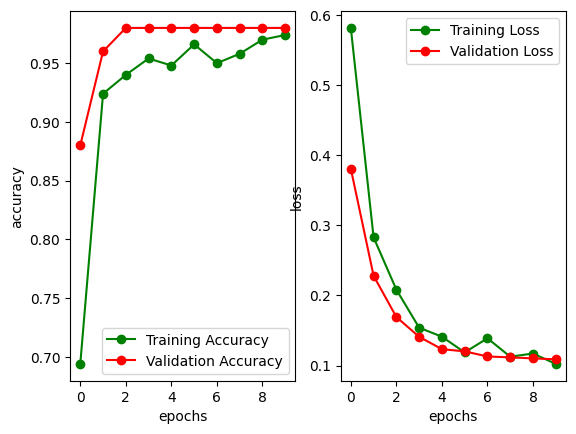

In [38]:
epochs=[i for i in range(10)]

fig,ax=plt.subplots(1,2)

train_acc=history.history["accuracy"]
train_loss=history.history["loss"]

val_acc=history.history["val_accuracy"]
val_loss=history.history["val_loss"]

ax[0].plot(epochs,train_acc,"go-",label="Training Accuracy")
ax[0].plot(epochs,val_acc,"ro-",label="Validation Accuracy")
ax[0].legend()
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("accuracy")

ax[1].plot(epochs,train_loss,"go-",label="Training Loss")
ax[1].plot(epochs,val_loss,"ro-",label="Validation Loss")
ax[1].legend()
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("loss")

In [39]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Tüm test verisini ve etiketleri topluyoruz
y_true = []
y_pred = []

for i in range(len(test_data)):
    x_batch, y_batch = test_data[i]
    
    # Tahmin yap
    preds = model.predict(x_batch)
    preds = [1 if p > 0.5 else 0 for p in preds]
    
    y_true.extend(y_batch)
    y_pred.extend(preds)

# Numpy array'e çevir
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion Matrix ve Classification Report
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Kedi", "Köpek"]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Confusion Matrix:
[[24  1]
 [ 0 25]]

Classification Report:
              precision    recall  f1-score   support

        Kedi       1.00      0.96      0.98        25
       Köpek       0.96      1.00      0.98        25

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


<Figure size 1500x500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Gerçek: 1\nTahmin: 1')

(np.float64(-0.5), np.float64(179.5), np.float64(179.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'Gerçek: 0\nTahmin: 0')

(np.float64(-0.5), np.float64(179.5), np.float64(179.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'Gerçek: 0\nTahmin: 1')

(np.float64(-0.5), np.float64(179.5), np.float64(179.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'Gerçek: 0\nTahmin: 0')

(np.float64(-0.5), np.float64(179.5), np.float64(179.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'Gerçek: 0\nTahmin: 0')

(np.float64(-0.5), np.float64(179.5), np.float64(179.5), np.float64(-0.5))

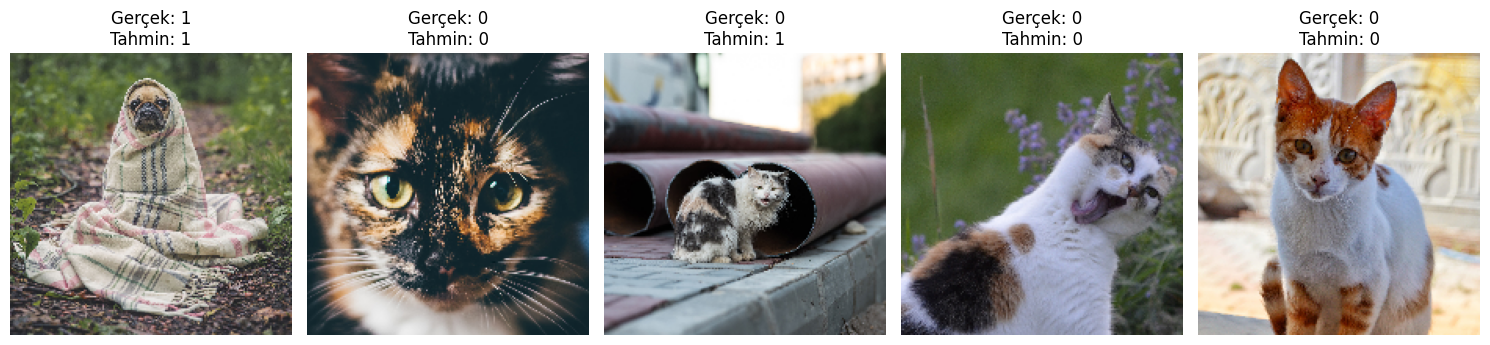

In [40]:
# Kaç resim görmek istiyorsan onu belirle
sample_num = 5  # Örn: 5 adet rastgele örnek
x_test_rgb = test_data[0][0]  # İlk batch'teki resimleri al (test_data flow_from_directory)
y_test_labels = test_data[0][1]

# Rastgele sample'lar al
indices = np.random.choice(len(x_test_rgb), sample_num, replace=False)
sample_images = x_test_rgb[indices]
sample_labels = y_test_labels[indices]

# Tahmin yap
predictions = model.predict(sample_images)
predicted_labels = [1 if p > 0.5 else 0 for p in predictions]

# Görselleştir
plt.figure(figsize=(15, 5))

for i in range(sample_num):
    plt.subplot(1, sample_num, i + 1)
    plt.imshow(sample_images[i])  # RGB olduğu için squeeze veya cmap gerekmez
    plt.title(f"Gerçek: {int(sample_labels[i])}\nTahmin: {predicted_labels[i]}", fontsize=12)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [41]:
def prepare_image_mobilenet(image_path, img_size):
    # 1. Resmi RGB (renkli) olarak oku
    img = cv2.imread(image_path)
    if img is None:
        print("Resim okunamadı. Lütfen dosya yolunu kontrol et.")
        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV BGR okur → RGB'ye çevir

    # 2. Resize işlemi
    img = cv2.resize(img, (img_size, img_size))

    # 3. Normalize et
    img = img / 255.0

    # 4. Diziye çevir ve model input şekline getir (1, 180, 180, 3)
    img = np.reshape(img, (1, img_size, img_size, 3))

    return img


In [42]:

image_path = "C:/Users/Harun/Desktop/MachineLearning_DeepLearning_Projects/Deep Learning/CNN-Cat-Dog-Classification/kopek3.jpeg"
test_img = prepare_image_mobilenet(image_path, img_size)

if test_img is not None:
    prediction = model.predict(test_img)
    print("Tahmin değeri:", prediction[0][0])

    if prediction[0][0] > 0.5:
        print("Tahmin: 🐶 Köpek")
    else:
        print("Tahmin: 🐱 Kedi")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Tahmin değeri: 0.78443146
Tahmin: 🐶 Köpek


In [43]:

image_path = "C:/Users/Harun/Desktop/MachineLearning_DeepLearning_Projects/Deep Learning/CNN-Cat-Dog-Classification/kedi2.jpeg"
test_img = prepare_image_mobilenet(image_path, img_size)

if test_img is not None:
    prediction = model.predict(test_img)
    print("Tahmin değeri:", prediction[0][0])

    if prediction[0][0] > 0.5:
        print("Tahmin: 🐶 Köpek")
    else:
        print("Tahmin: 🐱 Kedi")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tahmin değeri: 0.084281854
Tahmin: 🐱 Kedi
